<div style='background-image: url("george.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ROMY Data Retrievel</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>


<p style="width:50%;float:right;padding-left:50px">
<img src=./TarzanandJane.jpg>
<span style="font-size:smaller">
</span>
</p>

# Accessing the ROMY data via George (from the jungle)
## And retrieving co-located seismometer data

### Author:
* Jo Wassermann (LMU)

***

This notebook describes a simple and convenient way to retrieve data from three different ringlasers as well as ADR and ADS from different arrays (sizes) hosted by the Geophysical Observatory. It is also described how to mix this data with seismometer data from different sources (jane database as well as EIDA data retrieval).

**NOTE**
Data access via george/jane or tarzan is limited to internal usage. From outside it is only possible if you open an VPN connection to the geophysics network

Data available at george (this is also described in https://wiki.geophysik.uni-muenchen.de/dokuwiki/doku.php?id=obs:channels_scalings):

BW.DROMY..EJ*: Original data (Sagnac frequency)
BW.ROMY..HJ[UVW]: de-modulated data from the tilted rings of ROMY in 100 Hz sampling rate
BW.ROMY..BJ[UVW]: same but sampled with 20 Hz
BW.ROMY.10.HJZ  : de-modulated data from the horizontal ring (vertical component!) in 100 Hz
BW.ROMY.10.BJZ  : - ditto -

BW.ROMY.20.BJ[ZNE]: ADR data using only the inner array (GR.FUR; BW.FFB1; BW.FFB2; BW.FFB3) in 20 Hz sampling and valid approx. between 0.1 - 5 Hz. The rotations are computed with the obspy routinge .... after Spudich and Fletcher (2009)
BW.ROMY.20.BS[ZNE]: ADS with the same array and method than above 
BW.ROMY.20.BV     : volumetric strain - ditto -

BW.ROMY.30.BJ.... : all ADR and ADS data streams are also available with a delay of at least one month for the larger outer array (GR.FUR,BW.AFTL,BW.TON,BW.GERM,BW.GELB,BW.BIB)
- still work in progess to fill the database with this data

Data available at jane:
BW.* all Bavarian earthquake data + raw data of FFB array
GR.FUR and GR.WET

Open Acess Data (RLAS,PFORL) is also available via EIDA node:
http://erde.geophysik.uni-muenchen.de


In [7]:
# import libraries 
# ----------------
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from obspy import *

# all different 'jane' instances (jane,tarzan and george) support data retrieval via a fdsnws
# mechanism, which makes the use of it rather easy

from obspy.clients.fdsn import Client


4 Trace(s) in Stream:
BW.ROMY..BJZ   | 2018-01-23T09:30:00.009999Z - 2018-01-23T11:29:59.959999Z | 20.0 Hz, 144000 samples
BW.ROMY..BJN   | 2018-01-23T09:29:59.995399Z - 2018-01-23T11:29:59.945399Z | 20.0 Hz, 144000 samples
BW.ROMY..BJE   | 2018-01-23T09:29:59.978999Z - 2018-01-23T11:29:59.928999Z | 20.0 Hz, 144000 samples
BW.ROMY.10.BJZ | 2018-01-23T09:29:59.998600Z - 2018-01-23T11:29:59.998600Z | 20.0 Hz, 144001 samples


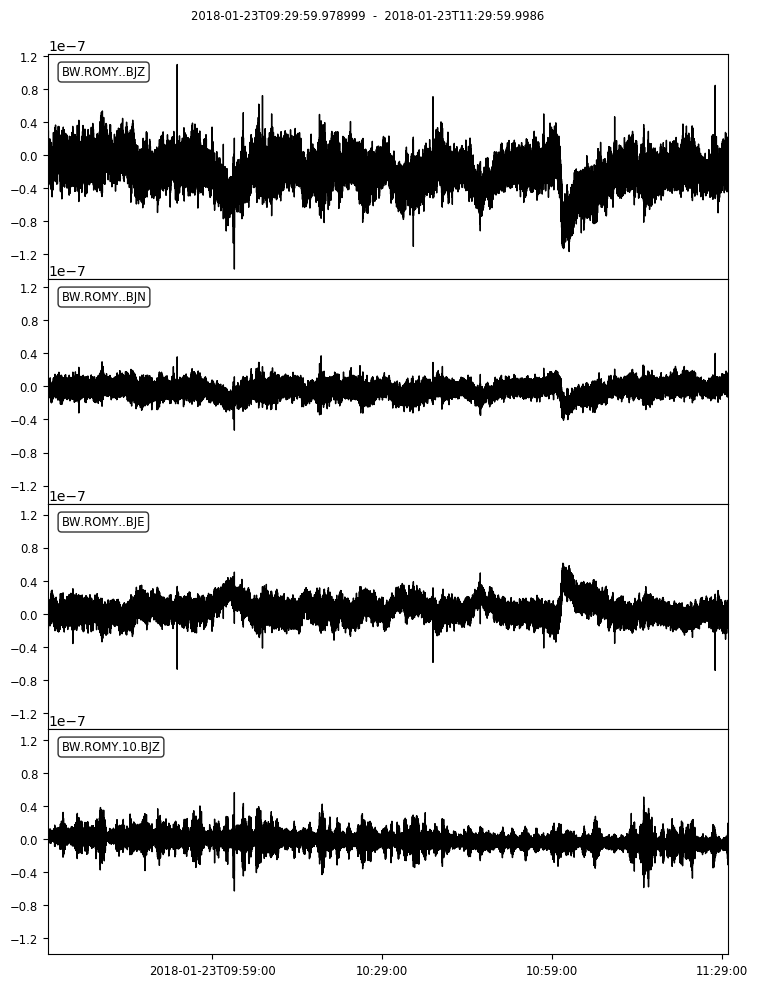

In [8]:
# Connect to George for retrieving
# 1. ROMY data (since 2016 10.?JZ)
# 2. ROMY-ADR from inner array data (2017,2018)
# 3. ROMY-ADR from outer array data (2017)
# 4. RLAS (Wettzell) data (not yet all years included but should be in parallel with ROMY data)
# 5. PFORL (Pinon Flat) data (at least in parts)


cl_george = Client('http://george',timeout=300)
start = UTCDateTime(2018,1,23,9,30)
end = start + 2*3600

romy = cl_george.get_waveforms('BW','ROMY','','BJ*',start,end)

inv = cl_george.get_stations(network='BW',station='ROMY',location='',channel='BJ*',starttime=start,level='response')
romy.remove_sensitivity(inventory=inv)
romy.rotate(method='->ZNE',inventory=inv,components=['UVW'])

# adding the vertical ring of ROMY; 

romy_z = cl_george.get_waveforms('BW','ROMY','10','BJZ',start,end,attach_response=True)
romy_z.remove_sensitivity()

romy += romy_z
romy.detrend('simple')
print(romy)

romy.plot()


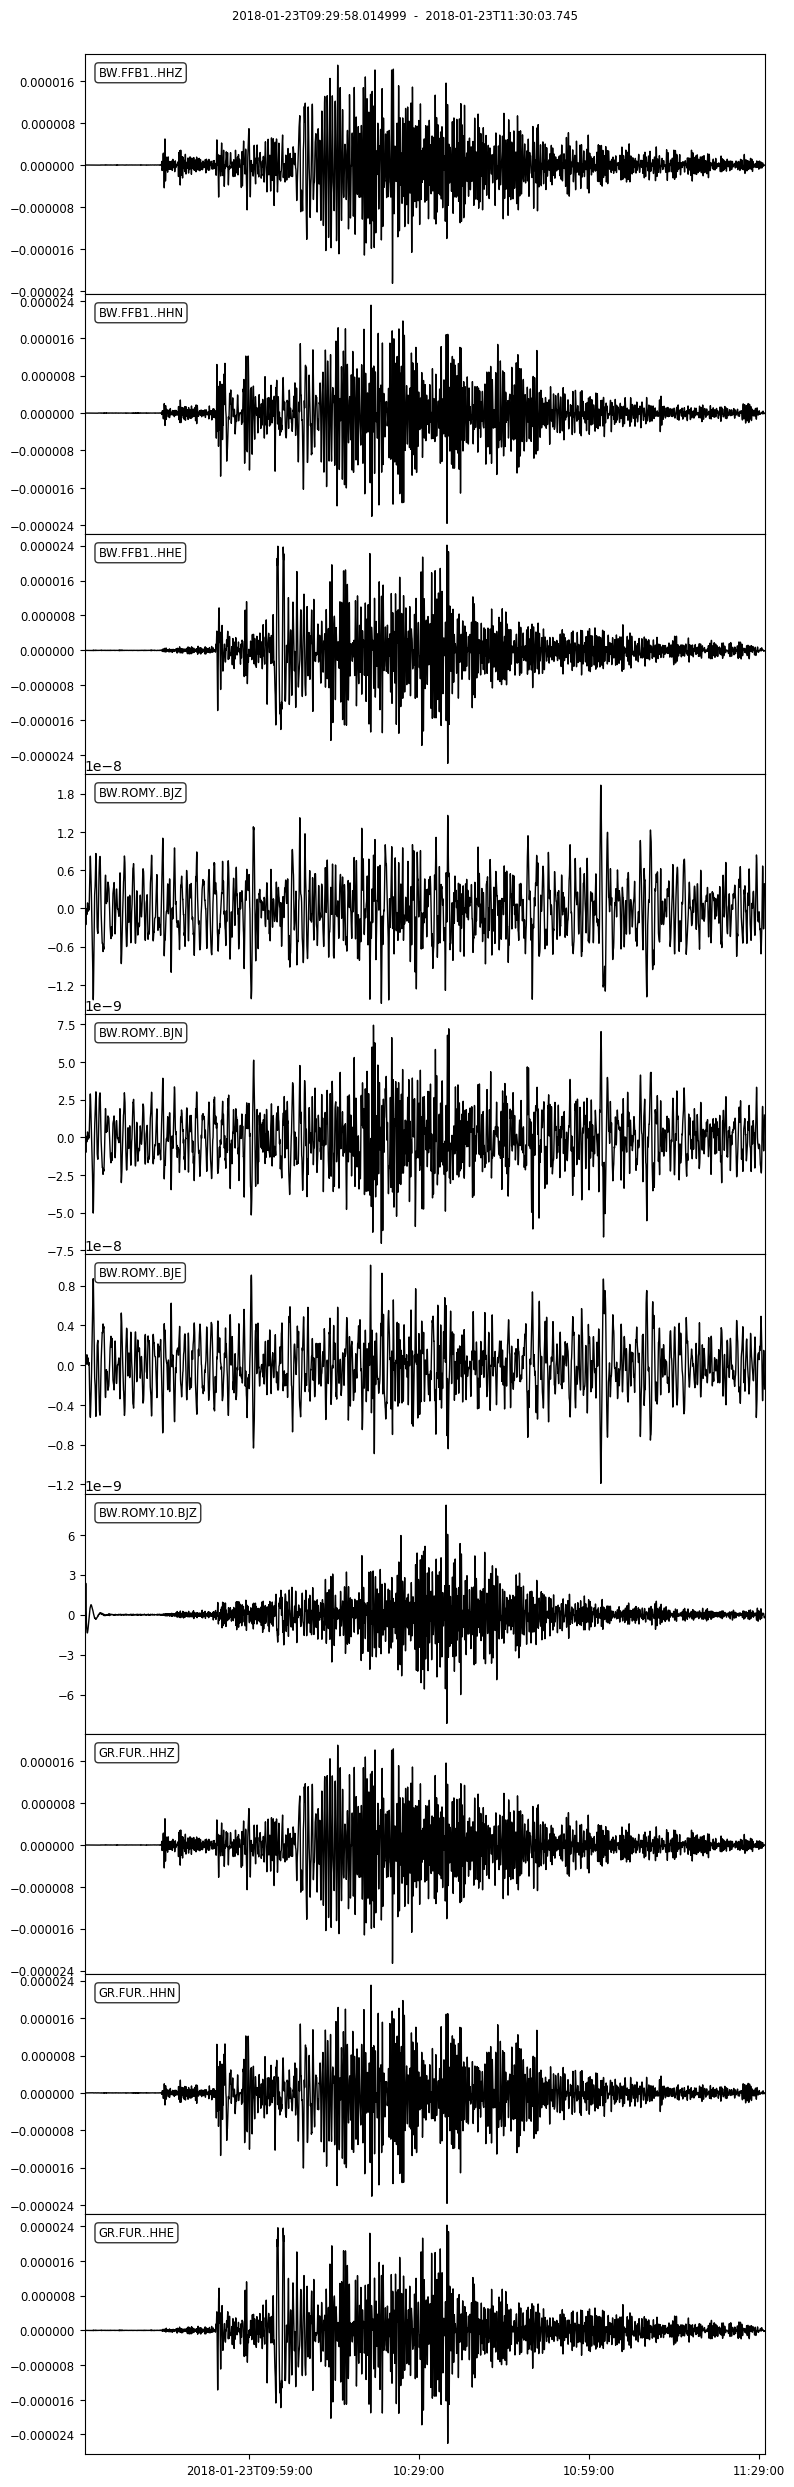

In [9]:
#adding data from two broadband stations (either FUR (GRSN) or FFB1 (borehole))
# in this example we grap our data via the newly implemented EIDA routing mechanism - you do not need to know where
# the data are stored physically (this will replace the arclink protocol in the near future)

from obspy.clients.fdsn import RoutingClient
cl_eida = RoutingClient("eida-routing")
cl_jane = Client('http://jane',timeout=500)
fur = cl_eida.get_waveforms(network='GR',station='FUR',location='',channel='HH*',starttime=start,\
                            endtime=end)
fur_inv = cl_eida.get_stations(network='GR',station='FUR',location='',channel='HH*',starttime=start,\
                            endtime=end,level="response")
fur.resample(sampling_rate=20,no_filter=False)
# we correct for the instrument and also switch to acceleration
fur.remove_response(water_level=10,inventory=fur_inv,output='ACC')

#the borehole data we pull from jane - our local database for seismic data
ffb1 = cl_jane.get_waveforms('BW','FFB1','','HH*',start,end,attach_response=True)
inv = cl_jane.get_stations(network='BW',station='FFB1',location='',channel='HH*',starttime=start,level='response')
ffb1.resample(sampling_rate=20,no_filter=False)
# we correct for the instrument and also switch to acceleration
ffb1.remove_response(water_level=10,output='ACC')
#the borehole station needs to be rotated in ZNE
ffb1.rotate(method='->ZNE',inventory=inv,components=['Z12'])

total = Stream()
total += romy
total += ffb1
total += fur
total.filter('bandpass',freqmin=0.01,freqmax=0.1)
total.plot(equal_scale=False)

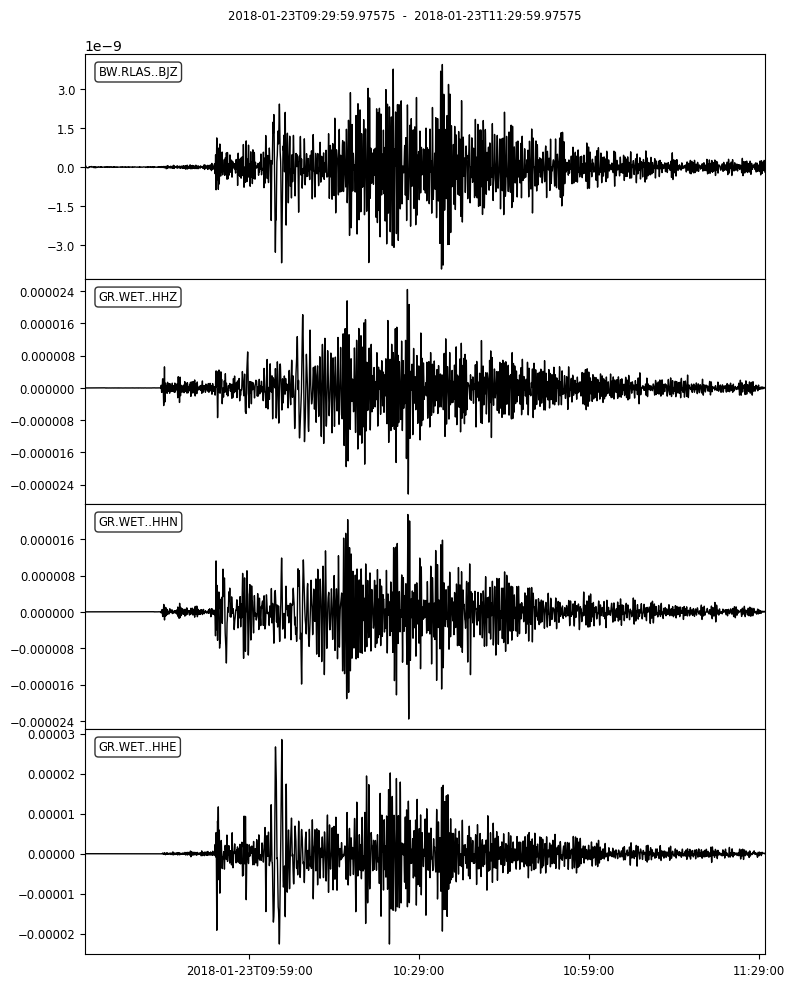

In [10]:
# of course you can also get Wettzell data via jane (or EIDA)
wet = cl_jane.get_waveforms('GR','WET','','HH*',start,end,attach_response=True)
wet.resample(sampling_rate=20,no_filter=False)
wet.remove_response(water_level=10,output='ACC')

# or the rotational data al
rlas_z = cl_george.get_waveforms('BW','RLAS','','BJZ',start,end,attach_response=True)
rlas_z.remove_sensitivity()

#in future RLAS data will also be accessible via George

combined = Stream()
combined += wet
combined += rlas_z
combined.detrend('simple')
combined.filter('bandpass',freqmin=0.01,freqmax=0.1)
combined.plot(equal_scale=False)


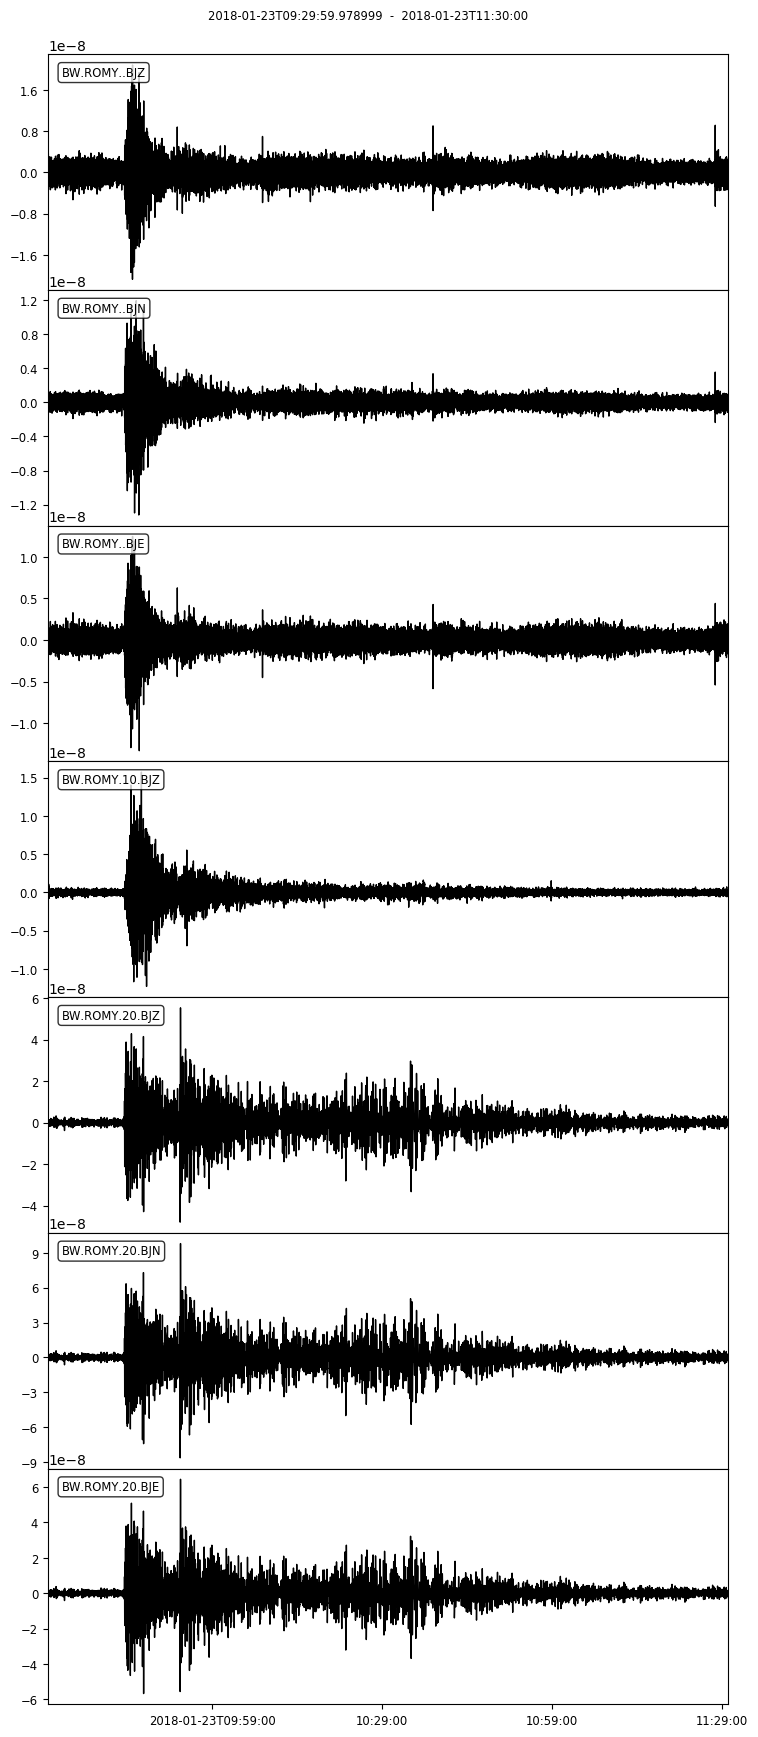

In [11]:
# let us try to compare ADR (Spudich method) with ROMY

romy = cl_george.get_waveforms('BW','ROMY','','BJ*',start,end)

inv = cl_george.get_stations(network='BW',station='ROMY',location='',channel='BJ*',starttime=start,level='response')
romy.remove_sensitivity(inventory=inv)
romy.rotate(method='->ZNE',inventory=inv,components=['UVW'])

# adding the vertical ring of ROMY

romy_z = cl_george.get_waveforms('BW','ROMY','10','BJZ',start,end,attach_response=True)
romy_z.remove_sensitivity()

romy += romy_z

adr = cl_george.get_waveforms('BW','ROMY','20','BJ*',start,end,attach_response=True)
adr.remove_sensitivity()
romy += adr
romy.detrend('simple')
romy.filter('bandpass',freqmin=0.1,freqmax=1.)
romy.plot(equal_scale=False)

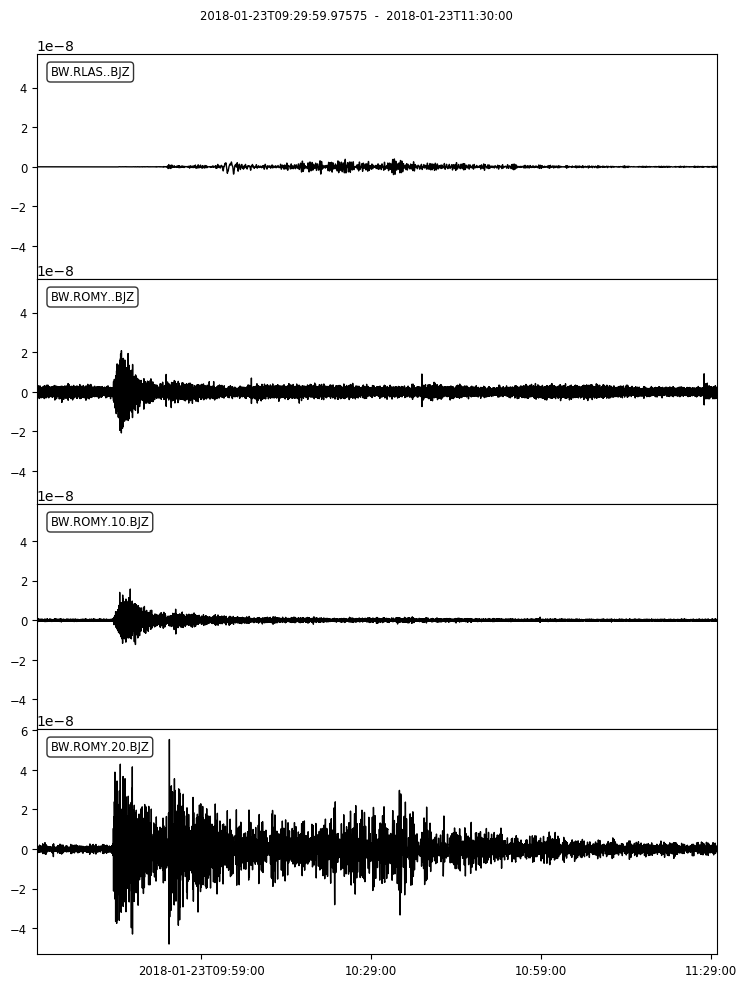

In [12]:
# retrieval of all vertical components 
# ------------------
zonly = Stream()
zonly += romy.select(channel="?JZ")
#zonly += pforl       # No data currently
zonly += rlas_z

zonly.plot()